In [ ]:
import numpy as np
import pandas as pd
columns = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label", "level"]
attack_type = {
    0: 'normal',
    1: 'DOS',
    2: 'Probe',
    3: 'R2L',
    4: 'U2R'
}

new_label = {
    'normal': 0,
    'apache2': 1,
    'back': 1,
    'mailbomb': 1,
    'processtable': 1,
    'snmpgetattack': 1,
    'teardrop': 1,
    'smurf': 1,
    'land': 1,
    'neptune': 1,
    'pod': 1,
    'udpstorm': 1,
    'nmap': 2,
    'ipsweep': 2,
    'portsweep': 2,
    'satan': 2,
    'mscan': 2,
    'saint': 2,
    'ftp_write': 3,
    'guess_passwd': 3,
    'snmpguess': 3,
    'imap': 3,
    'spy': 3,
    'warezclient': 3,
    'warezmaster': 3,
    'multihop': 3,
    'phf': 3,
    'imap': 3,
    'named': 3,
    'sendmail': 3,
    'xlock': 3,
    'xsnoop': 3,
    'worm': 3,
    'ps': 4,
    'buffer_overflow': 4,
    'perl': 4,
    'rootkit': 4,
    'loadmodule': 4,
    'xterm': 4,
    'sqlattack': 4,
    'httptunnel': 4
}

# Preprocessing dataset

Drop na and duplicates

In [ ]:
train = pd.read_csv("NSL-KDD/KDDTrain+.txt", header=None)
train.columns = columns
train = train.dropna()
train = train.drop_duplicates()
test = pd.read_csv("NSL-KDD/KDDTest+.txt", header=None)
test.columns = columns
test = test.dropna()
test = test.drop_duplicates()

In [ ]:
last_index_train = train.index.to_list()[-1]
df = pd.concat([train, test])

In [ ]:
df.shape

OneHotEncoder at `protocol_type`, `service` and `flag` 

In [ ]:
df.dtypes

In [ ]:
from preprocessing import encode_text_dummy
encode_text_dummy(df=df, name="protocol_type")
encode_text_dummy(df=df, name="service")
encode_text_dummy(df=df, name="flag")

In [ ]:
df

Split to train and test set

In [ ]:
train = df.iloc[:last_index_train+1]
test = df.iloc[last_index_train+1:]
X_train = train.drop(columns=['label', 'level'])
y_train = train.label.map(new_label).map(attack_type)
X_test = test.drop(columns=['label', 'level'])
y_test = test.label.map(new_label).map(attack_type)

Normalize trainset/testset

In [ ]:
from sklearn.preprocessing import MinMaxScaler
features = X_train.columns
scalser = MinMaxScaler()
scalser.fit(X_train)
X_train = scalser.transform(X_train)
X_test = scalser.transform(X_test)

SMOTE for balance dataset

In [ ]:
y_train.value_counts()

In [ ]:
from imblearn.over_sampling import SMOTE

desired_samples = {
    "U2R": 5000,
    "R2L": 5000
}

bal = SMOTE(sampling_strategy=desired_samples)

X_train, y_train = bal.fit_resample(X_train, y_train)

In [ ]:
y_train.value_counts()

# DEEP NEURAL MODEL

In [ ]:
X_train = pd.DataFrame(X_train, columns=features)
X_test = pd.DataFrame(X_test, columns=features)
y_train = pd.DataFrame(y_train, columns=['label'])
y_test = pd.DataFrame(y_test, columns=['label'])
encode_text_dummy(y_train, 'label')
encode_text_dummy(y_test, 'label')

In [ ]:
X_train.to_csv("NSL-KDD/X_train.csv")
y_train.to_csv("NSL-KDD/y_train.csv")
X_test.to_csv("NSL-KDD/X_test.csv")
y_test.to_csv("NSL-KDD/y_test.csv")

In [ ]:
X_train.head()

In [ ]:
y_train.head()

In [ ]:
import tensorflow as tf
from art.estimators.tensorflow import TensorFlowV2Estimator

layers = [
    tf.keras.layers.Dense(X_train.shape[0], activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
]
loss_object = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
dnn = tf.keras.models.Sequential(layers=layers)
dnn.compile(
    loss=loss_object,
    optimizer=optimizer,
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
    ]
)
dnn.fit(
    x=X_train,
    y=y_train.values,
    epochs=5,
    batch_size=1024
)

In [ ]:
dnn.save("NSL-KDD/dnn.h5")

# ART

load model, train and test set

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np

dnn = tf.keras.models.load_model("NSL-KDD/dnn.h5")
X_train = pd.read_csv("NSL-KDD/X_train.csv").drop(columns=['Unnamed: 0'])
y_train = pd.read_csv("NSL-KDD/y_train.csv").drop(columns=['Unnamed: 0'])
X_test = pd.read_csv("NSL-KDD/X_test.csv").drop(columns=['Unnamed: 0'])
y_test = pd.read_csv("NSL-KDD/y_test.csv").drop(columns=['Unnamed: 0'])

In [ ]:
from art.estimators.classification import TensorFlowV2Classifier
loss_object = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
dnn_model = TensorFlowV2Classifier(
    model=dnn,
    loss_object=loss_object,
    optimizer=optimizer,
    nb_classes=5,
    input_shape=X_train.shape
)

In [ ]:
from evaluation_metric import evaluate_metric
evaluate_metric(y_pred=dnn_model.predict(x=X_test), y_true=y_test.values)

In [ ]:
samples = X_test.sample(n=500)
y_samples = y_test.iloc[samples.index]

In [ ]:
from evaluation_metric import evaluate_metric
evaluate_metric(
    y_pred=dnn_model.predict(x=samples),
    y_true=y_samples
)

calculate shap values

In [ ]:
# background = X_train.sample(500)
# background.to_csv("NSL-KDD/samples/background.csv")
# samples.to_csv("NSL-KDD/samples/samples.csv")
# y_samples.to_csv("NSL-KDD/samples/y_samples.csv")

In [ ]:
import shap
from shap_importance import shap_importance

background = pd.read_csv("NSL-KDD/samples/background.csv").drop(columns=["Unnamed: 0"])
samples = pd.read_csv("NSL-KDD/samples/samples.csv").drop(columns=["Unnamed: 0"])
y_samples = pd.read_csv("NSL-KDD/samples/y_samples.csv").drop(columns=["Unnamed: 0"])

explainer = shap.DeepExplainer(model=dnn, data=background.values)
shap_vals = explainer.shap_values(samples.values)

accuracy plot when increase number of adversarial features

In [ ]:
import pickle
import pandas as pd
import numpy as np
import tensorflow as tf
from adversarial_n_best_worst_features import adversarial_n_best_worst_features
from shap_importance import shap_importance
from art.attacks.evasion.fast_gradient import FastGradientMethod
from art.attacks.evasion.iterative_method import BasicIterativeMethod
from art.attacks.evasion.saliency_map import SaliencyMapMethod
from art.attacks.evasion.carlini import CarliniL0Method, CarliniLInfMethod ,CarliniL2Method
from art.attacks.evasion.deepfool import DeepFool
from art.estimators.classification import TensorFlowV2Classifier

dnn = tf.keras.models.load_model("NSL-KDD/dnn.h5")
X_train = pd.read_csv("NSL-KDD/X_train.csv").drop(columns=['Unnamed: 0'])
y_train = pd.read_csv("NSL-KDD/y_train.csv").drop(columns=['Unnamed: 0'])
X_test = pd.read_csv("NSL-KDD/X_test.csv").drop(columns=['Unnamed: 0'])
y_test = pd.read_csv("NSL-KDD/y_test.csv").drop(columns=['Unnamed: 0'])


loss_object = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
dnn_model = TensorFlowV2Classifier(
    model=dnn,
    loss_object=loss_object,
    optimizer=optimizer,
    nb_classes=5,
    input_shape=X_train.shape
)


# background = pd.read_csv("NSL-KDD/samples/background.csv").drop(columns=["Unnamed: 0"])
samples = pd.read_csv("NSL-KDD/samples/samples.csv").drop(columns=["Unnamed: 0"])
y_samples = pd.read_csv("NSL-KDD/samples/y_samples.csv").drop(columns=["Unnamed: 0"])
shap_vals = pickle.load(open("NSL-KDD/samples/shap_vals_of_samples.pkl","rb"))
shap_vals = [np.array(val) for val in shap_vals]

In [2]:
adversarial_algs = {
    "FSGM": FastGradientMethod(estimator=dnn_model, eps=0.2),
    "BIM": BasicIterativeMethod(estimator=dnn_model, eps=0.2, max_iter=100, batch_size=32),
    # "CW-L0": CarliniL0Method(classifier=dnn_model, max_iter=10, verbose=True),
    # "CW-LInf": CarliniLInfMethod(classifier=dnn_model, max_iter=10),
    "CW-L2": CarliniL2Method(classifier=dnn_model, max_iter=10),
    "JSMA": SaliencyMapMethod(classifier=dnn_model,theta=0.1,gamma=1, batch_size=1),
    "DeepFool": DeepFool(classifier=dnn_model, max_iter=100, epsilon=0.000001, nb_grads=10, batch_size=1),
}

# 
full_features = samples.columns
selected_features = [f for f in shap_importance(full_features, shap_val_of_sample=shap_vals).column_name.values.tolist() \
                     if 'protocol_type' not in f and 'service' not in f and 'flag' not in f]

In [3]:
import pickle as plk
acc_list = []

for alg_name in adversarial_algs:
    print(f"{alg_name}")
    alg = adversarial_algs[alg_name]
    org_samples = samples.copy()
    adv_samples = alg.generate(x=org_samples.values) + np.random.uniform(0,10**-10, size=org_samples.shape)
    adv_samples = pd.DataFrame(adv_samples, columns=full_features)
    print(f"\t{alg_name} finish generate adversarial.")
    pd.DataFrame(np.clip(adv_samples,0,1), columns=full_features).to_csv(f"NSL-KDD/samples/attack/{alg_name}_sample.csv")
    
    acc_list.append(adversarial_n_best_worst_features(
        model=dnn_model,
        selected_features=selected_features,
        samples=org_samples,
        adv_samples=adv_samples,
        y_true=y_samples
    ))
    
    plk.dump(acc_list[-1], open(f'NSL-KDD/samples/acc_attack/acc_{alg_name}.plk',"wb"))

FSGM
	FSGM finish generate adversarial.
BIM


	BIM finish generate adversarial.
CW-L2


C&W L_2:   0%|          | 0/500 [00:00<?, ?it/s]

C&W L_2: 100%|██████████| 500/500 [7:53:53<00:00, 56.87s/it]  


	CW-L2 finish generate adversarial.
JSMA


JSMA: 100%|██████████| 500/500 [16:06<00:00,  1.93s/it]


	JSMA finish generate adversarial.
DeepFool


DeepFool:   0%|          | 0/500 [00:00<?, ?it/s]

DeepFool: 100%|██████████| 500/500 [32:28<00:00,  3.90s/it]  


	DeepFool finish generate adversarial.


Fast Gradient Method

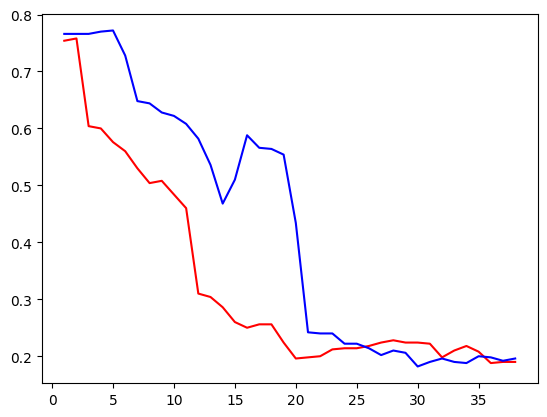

In [4]:
import matplotlib.pyplot as plt
plt.plot(
    [a+1 for a in range(len(selected_features))],
    acc_list[0][0], 'red')

plt.plot(
    [a+1 for a in range(len(selected_features))],
    acc_list[0][1] , 'blue')

plt.show()

Basic Interactive Method

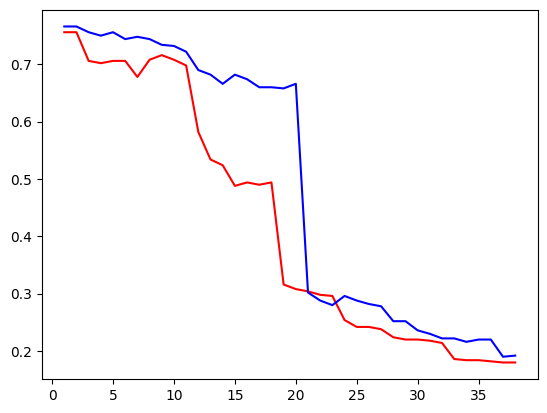

In [5]:
import matplotlib.pyplot as plt
plt.plot(
    [a+1 for a in range(len(selected_features))],
    acc_list[1][0], 'red')

plt.plot(
    [a+1 for a in range(len(selected_features))],
    acc_list[1][1] , 'blue')

plt.show()

Carlini L2 Method

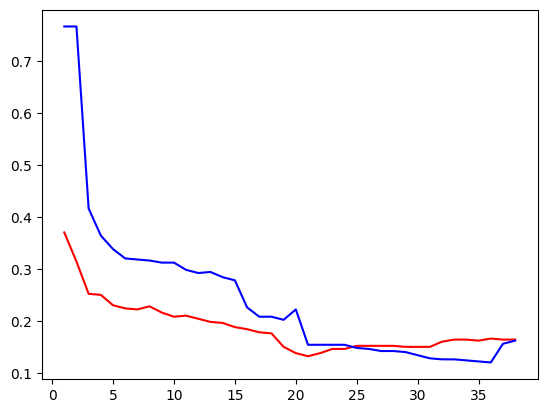

In [6]:
import matplotlib.pyplot as plt
plt.plot(
    [a+1 for a in range(len(selected_features))],
    acc_list[2][0], 'red')

plt.plot(
    [a+1 for a in range(len(selected_features))],
    acc_list[2][1] , 'blue')

plt.show()

Saliency Map Method

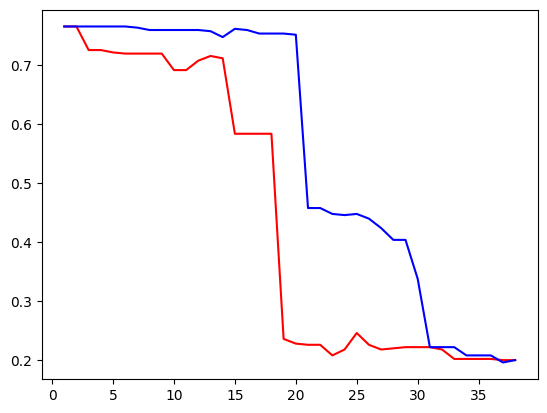

In [8]:
import matplotlib.pyplot as plt
plt.plot(
    [a+1 for a in range(len(selected_features))],
    acc_list[3][0], 'red')

plt.plot(
    [a+1 for a in range(len(selected_features))],
    acc_list[3][1] , 'blue')

plt.show()

DeepFool

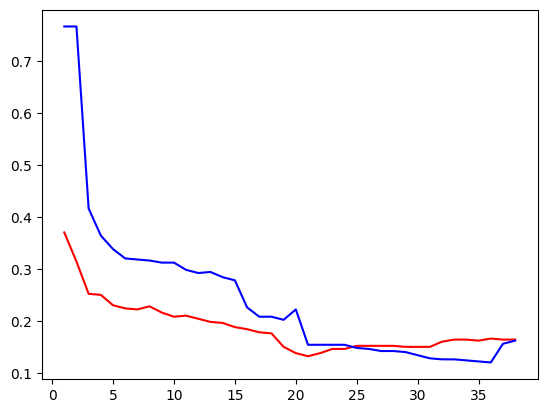

In [9]:
import matplotlib.pyplot as plt
plt.plot(
    [a+1 for a in range(len(selected_features))],
    acc_list[4][0], 'red')

plt.plot(
    [a+1 for a in range(len(selected_features))],
    acc_list[4][1] , 'blue')

plt.show()